# Visualizing the Loop

More insight into the simple function behind `pipe("a cat running in the sky")`.

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

In [2]:
from huggingface_hub import notebook_login
from pathlib import Path
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## loading vaious models

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## About the Schedular

With SD, when training we add a bit of noise into that & then try to undo that.

When predicting, we simply add some noise first & it will reduce the noise amount in each step.

In [10]:
# our scheduler has 1000 steps when training
# but when predicting, we reduce that into 20 steps
scheduler.set_timesteps(20)

In [11]:
# these is represntation of original steps at each point
scheduler.timesteps

tensor([999.0000, 946.4211, 893.8421, 841.2632, 788.6842, 736.1053, 683.5263,
        630.9474, 578.3684, 525.7895, 473.2105, 420.6316, 368.0526, 315.4737,
        262.8947, 210.3158, 157.7368, 105.1579,  52.5789,   0.0000],
       dtype=torch.float64)

In [12]:
# these are noise multiplier
scheduler.sigmas

tensor([14.6146, 10.7468,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000])

## Let's add a noise to an existing image

In [15]:
def pil_to_latents(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

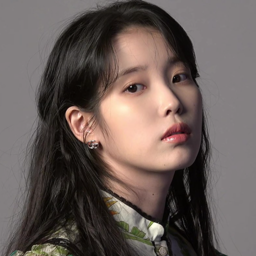

In [51]:
source_image = Image.open("./images/iu.png").convert("RGB").resize((512, 512))
source_image.resize((256, 256))

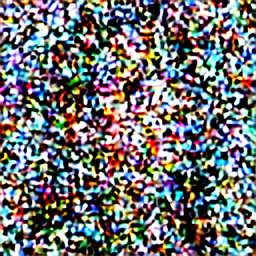

In [59]:
source_latents = pil_to_latents(source_image)

fast_forwared_steps = 15
noise = torch.randn_like(source_latents) 
source_latents_noised = scheduler.add_noise(source_latents, noise, timesteps=torch.tensor([scheduler.timesteps[fast_forwared_steps]]))

latents_to_pil(source_latents_noised)[0].resize((256, 256))

## Using the above source latents inside the Loop

0it [00:00, ?it/s]

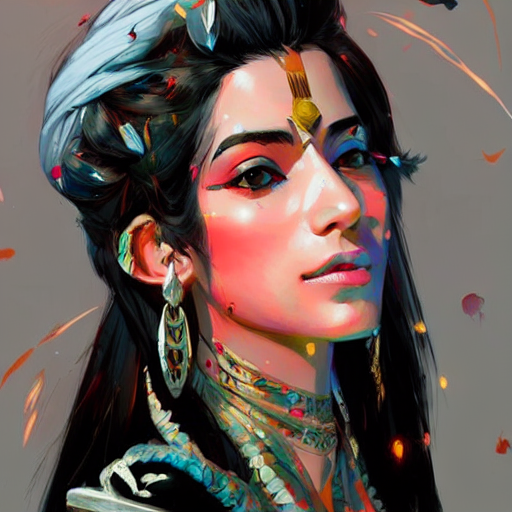

In [62]:
# Some settings
prompt = ["a ultradetailed beautiful panting of a stylish indian woman with a sword, by conrad roset, greg rutkowski and makoto shinkai, trending on artstation"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Use the source latents
latents = source_latents_noised
latents = latents.to(torch_device)

latents_history = []

# Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        if i <= fast_forwared_steps:
            continue
            
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        latents_history.append(latents)

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [45]:
import math

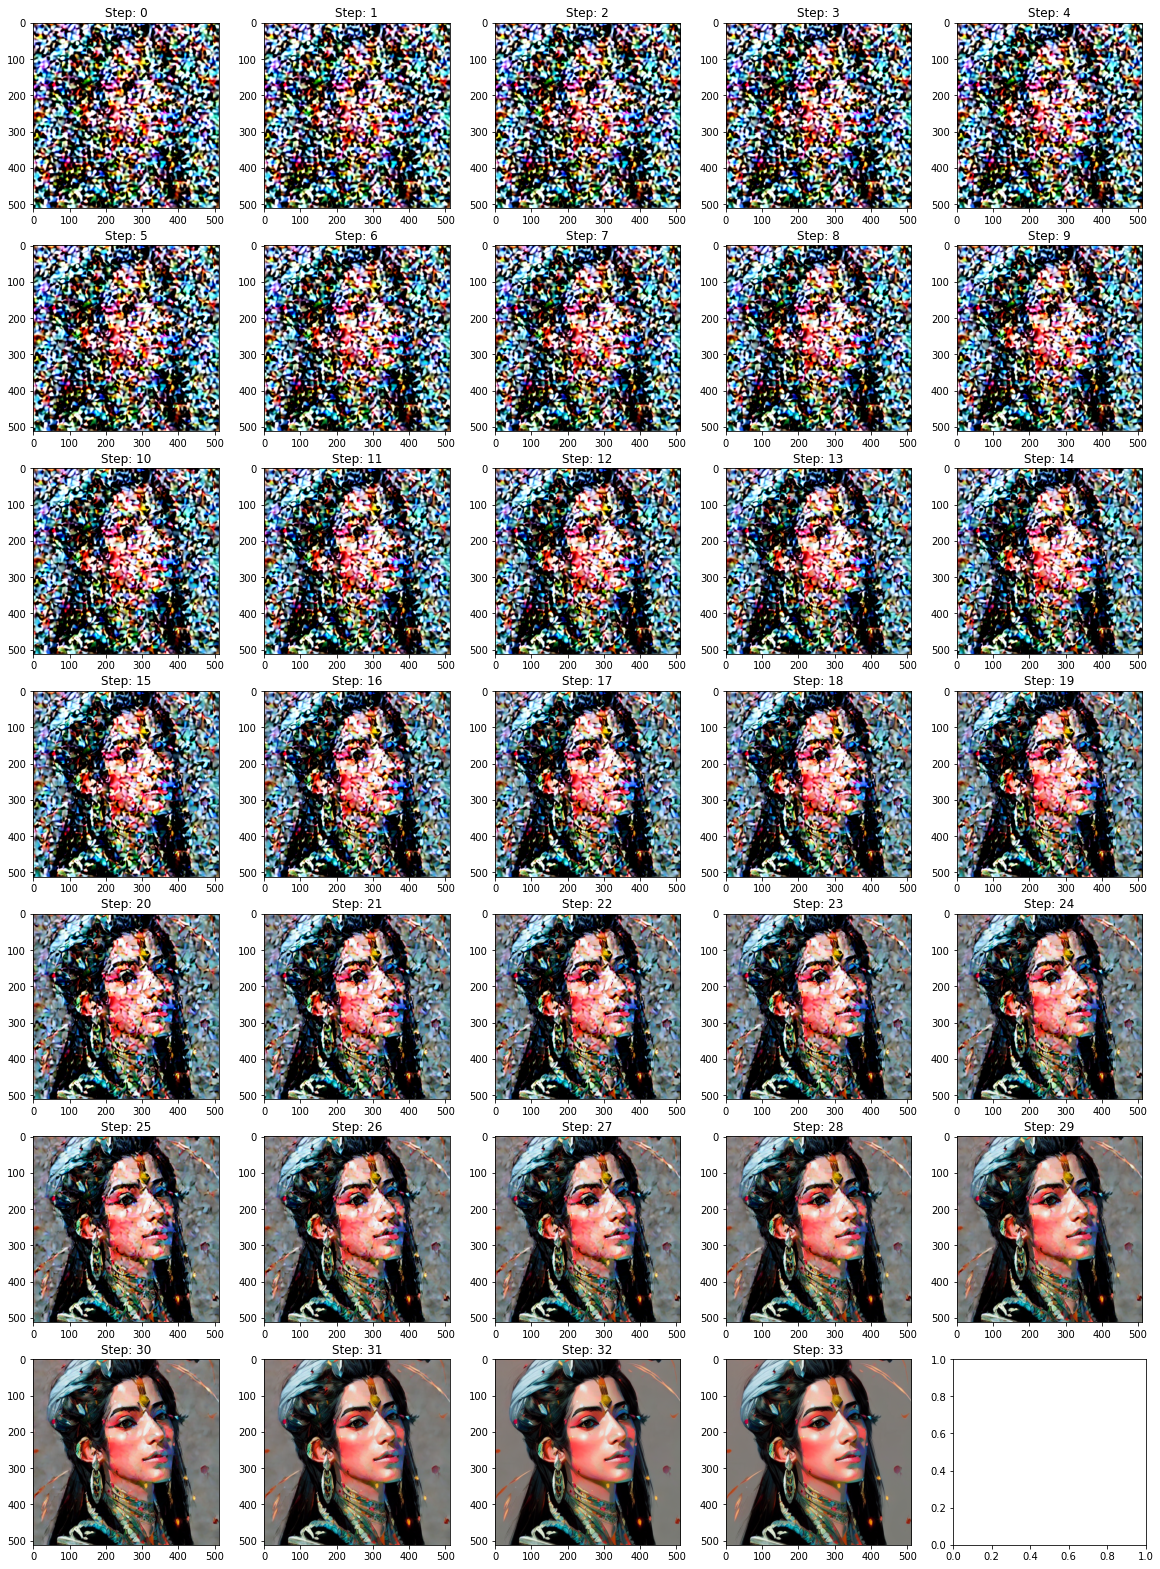

In [63]:
n_cols = 5
n_rows = (int)(math.ceil(len(latents_history) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

for y in range(n_rows):
    for x in range(n_cols):
        index = y*n_cols + x
        if index >= len(latents_history):
            break
            
        latents = 1 / 0.18215 * latents_history[index]
        
        with torch.no_grad():
            im_s = vae.decode(latents).sample[0]
            
        im_s = (im_s * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
        axes[y, x].title.set_text(f"Step: {index}")
        axes[y, x].imshow(im_s)

## This is amazing

Basically, we can control both `fast_forwared_steps` and `num_steps` to control the image we need to look for.

If the `fast_forward_steps` we will get more data from the source image, otherwise it will be less.
<br/>
We can use `num_steps` to train more

## Putting Everything Together

In [81]:
def mix_sd(source_image_path, prompt, ff_step = 15, num_steps = 50, source_max_steps=-1):
    prompt = [prompt]
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1
    
    if source_max_steps == -1:
        scheduler.set_timesteps(num_steps)
    else:
        scheduler.set_timesteps(source_max_steps)
    
    source_image = Image.open(source_image_path).convert("RGB").resize((width, height))
    
    source_latents = pil_to_latents(source_image)    
    noise = torch.randn_like(source_latents) 
    source_latents_noised = scheduler.add_noise(source_latents, noise, timesteps=torch.tensor([scheduler.timesteps[ff_step]]))

    source_noised_image = latents_to_pil(source_latents_noised)[0]

    # Prep text 
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_steps)

    # Use the source latents
    latents = source_latents_noised
    latents = latents.to(torch_device)

    latents_history = []

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            if i <= fast_forwared_steps:
                continue

            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            latents_history.append(latents)

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    
    final_image = pil_images[0]
    
    return source_image, source_noised_image, final_image

In [83]:
def __d(imgs):
    w,h = imgs[0].size
    cols=3
    rows=1
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid.resize(((int)(grid.size[0]/2), (int)(grid.size[1]/2)))

In [65]:
prompt = "a ultradetailed beautiful panting of a stylish indian woman with a sword, by conrad roset, greg rutkowski and makoto shinkai, trending on artstation"

0it [00:00, ?it/s]

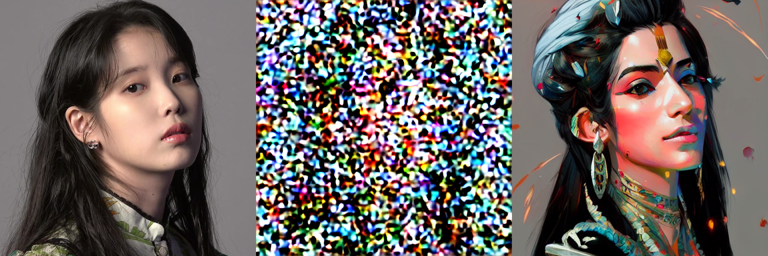

In [84]:
__d(mix_sd("./images/iu.png", prompt, ff_step=15, num_steps=50))

0it [00:00, ?it/s]

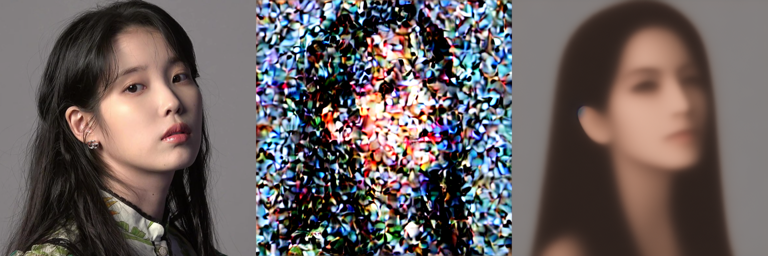

In [89]:
__d(mix_sd("./images/iu.png", prompt, ff_step=30, num_steps=50))

0it [00:00, ?it/s]

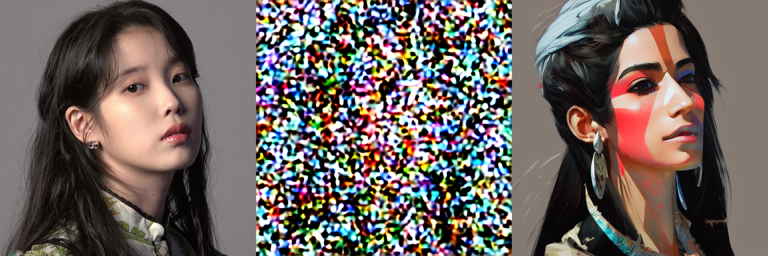

In [105]:
__d(mix_sd("./images/iu.png", prompt, ff_step=5, num_steps=60, source_max_steps=20))